### Logistic Regression Modelling 

### Import relevant libraries and dataset

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from joblib import dump, load

In [2]:
df = pd.read_csv('../../Data/processed/weatherAUS_imputed.csv')
display(df.head())
df.shape

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637


(67725, 18)

In [3]:
#Before starting our modelling, we will define a ROC curve function to dipslay the results 
def roc_curve_custom(model, X, y):
    y_score = model.predict_proba(X)[:, 1] 
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='model')
    roc_display.plot(color='orange', label=f'clf model (auc = {np.round(roc_auc,2)})')
    plt.grid(True)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label='Random (auc = 0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
#We will also define a function to display the confusion matrix and classification_report 
def confusion_matrix_classification_report(test, pred_test, train, pred_train):
    #calculate confusion matrix 
    conf_matrix = confusion_matrix(test, pred_test)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale if needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(test, pred_test)

    # Print the classification report
    print('-------------------------')
    print(report)

    # Calculate accuracy for both sets
    print('-------------------------')
    train_accuracy = accuracy_score(train, pred_train)
    test_accuracy = accuracy_score(test, pred_test)
    print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

### Logistic Regression Classifier

### 1.Without over or undersampling

In [5]:
data = df.drop(columns=['RainTomorrow', 'Location', 'Date'])
target = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### 1.1. Default Logistic Regression with model with gini criterion and no max_depth

In [6]:

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)


C:\Users\Abhishek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

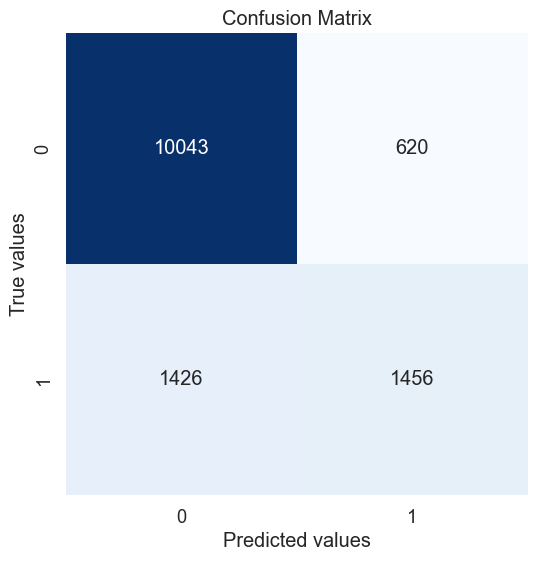

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     10663
         1.0       0.70      0.51      0.59      2882

    accuracy                           0.85     13545
   macro avg       0.79      0.72      0.75     13545
weighted avg       0.84      0.85      0.84     13545

-------------------------
Accuracy Train Set: 0.848 Accuracy Test Set: 0.849


In [7]:
y_pred_test= logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_test, y_train, y_pred_train)

### 1.2 GridSearch

In [8]:
logreg = LogisticRegression()
param_grid = {
    'C': [1, 10, 100, 1000, 10000, 100000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'fit_intercept': [True, False],
    'max_iter': [50, 100, 150],
    'random_state': [42]
}
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

logreg_fit=grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
grid_logreg = grid_search.best_estimator_


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best hyperparameters:  {'C': 10000, 'fit_intercept': True, 'max_iter': 50, 'random_state': 42, 'solver': 'newton-cg'}


C:\Users\Abhishek\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [9]:
logreg_fit = grid_logreg.fit(X_train, y_train)

C:\Users\Abhishek\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [10]:
dump(logreg_fit, 'logreg_fit.joblib')

['logreg_fit.joblib']

In [11]:
logreg_fit = load('logreg_fit.joblib')



In [12]:
logreg_best= LogisticRegression(C=10000, fit_intercept=True, max_iter=50, random_state=42, solver='newton-cg')

### 1.3 Model with best parameters

In [13]:

logreg_best.fit(X_train, y_train)

C:\Users\Abhishek\anaconda3\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(C=10000, max_iter=50, random_state=42, solver='newton-cg')

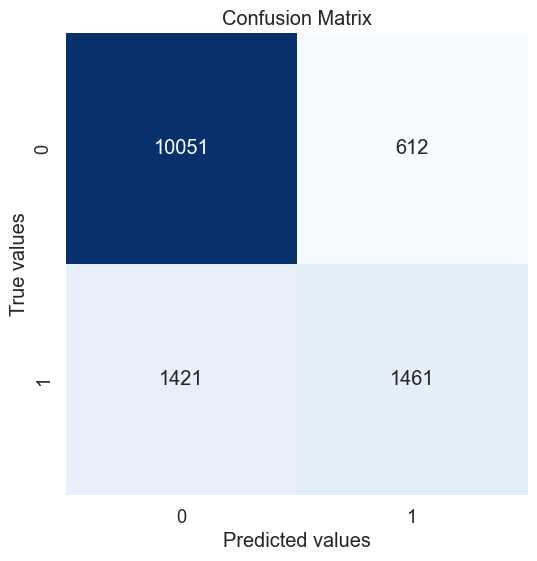

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     10663
         1.0       0.70      0.51      0.59      2882

    accuracy                           0.85     13545
   macro avg       0.79      0.72      0.75     13545
weighted avg       0.84      0.85      0.84     13545

-------------------------
Accuracy Train Set: 0.85 Accuracy Test Set: 0.85


In [14]:
y_pred_test_best= grid_logreg.predict(X_test)
y_pred_train_best = grid_logreg.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_test_best, y_train, y_pred_train_best)

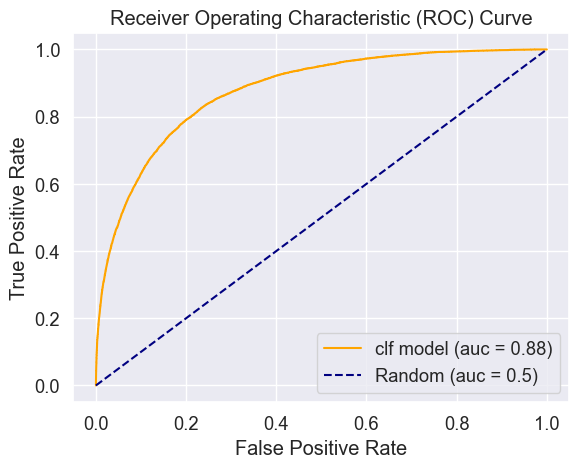

In [15]:
roc_curve_custom(grid_logreg, X_train, y_train)

Precision: It measures the accuracy of positive predictions. In this context, for class 0.0, the precision is 0.88, which means that when the model predicts an instance as belonging to class 0.0, it is correct 88% of the time. For class 1.0, the precision is 0.70, meaning the model is correct 70% of the time when predicting class 1.0.

Recall: It measures the ability of the model to capture all positive instances. For class 0.0, the recall is 0.94, indicating that the model correctly identifies 94% of all actual instances of class 0.0. For class 1.0, the recall is 0.51, indicating that the model captures 51% of all actual instances of class 1.0.

F1-score: It is the harmonic mean of precision and recall. It provides a balance between precision and recall. A high F1-score implies both high precision and high recall. In this case, for class 0.0, the F1-score is 0.91, and for class 1.0, it is 0.59.

Accuracy: It represents the proportion of correctly classified instances out of all instances. Here, the overall accuracy is 0.85, meaning the model correctly predicts the class for 84% of all instances.

Macro Avg: It calculates the average of the precision, recall, and F1-score across both classes, without considering class imbalance.

Weighted Avg: It calculates the average of the precision, recall, and F1-score, weighted by the number of instances in each class. This gives more weight to classes with more instances, which is useful when dealing with class imbalance.

As we can see, the model does a good job predicting class 0 but the precisin, recall and f1-score is quite low for class 1. That is most likley due to the imbalance of the dataset. So let's repeat the modelling process with over and undersampling techniques. 

### 2. Oversampling  

### 2.1 Random Oversampling 

In [16]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(data,target)

In [17]:

logreg_ros= LogisticRegression(C=10000, fit_intercept=True, max_iter=50, random_state=42, solver='newton-cg')
logreg_ros.fit(X_ros, y_ros)

C:\Users\Abhishek\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Abhishek\anaconda3\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


LogisticRegression(C=10000, max_iter=50, random_state=42, solver='newton-cg')

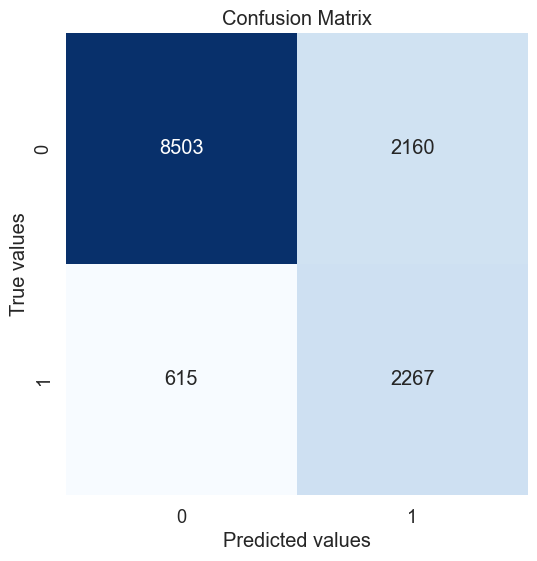

-------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86     10663
         1.0       0.51      0.79      0.62      2882

    accuracy                           0.80     13545
   macro avg       0.72      0.79      0.74     13545
weighted avg       0.84      0.80      0.81     13545

-------------------------
Accuracy Train Set: 0.797 Accuracy Test Set: 0.795


In [18]:
y_pred_test_ros= logreg_ros.predict(X_test)
y_pred_train_ros = logreg_ros.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_test_ros, y_train, y_pred_train_ros)

With random over sampling we get a better recall score for class 1: 0.79 vs. 0.51 with the best parameter model.  However, now the precision score of class 1 is very low with 0.51. Also, the recall and f1 score for class 0 are lower than before. The lower scores for class 0 might be due to the fact that random oversampling sometimes changes the distribution of the underlying data. Also the model accuracy is lower than in the previous model: 0.797, before it was at 0.85.

### 2.2 SMOTE

In [19]:
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train,y_train)

In [20]:
logreg_sm= LogisticRegression(C=10000, fit_intercept=True, max_iter=50, random_state=42, solver='newton-cg')
logreg_sm.fit(X_sm, y_sm)

LogisticRegression(C=10000, max_iter=50, random_state=42, solver='newton-cg')

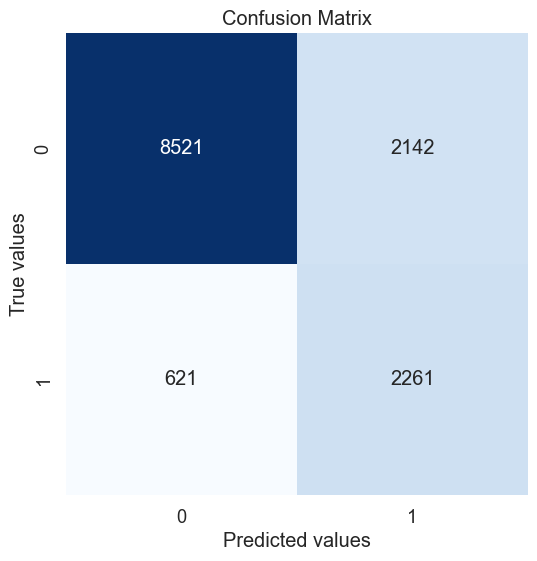

-------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86     10663
         1.0       0.51      0.78      0.62      2882

    accuracy                           0.80     13545
   macro avg       0.72      0.79      0.74     13545
weighted avg       0.84      0.80      0.81     13545

-------------------------
Accuracy Train Set: 0.798 Accuracy Test Set: 0.796


In [21]:
y_pred_test_sm= logreg_sm.predict(X_test)
y_pred_train_sm = logreg_sm.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_test_sm, y_train, y_pred_train_sm)

Similar to random over sampling we get a better recall score for class 1: 0.78 vs. 0.51 with the best parameter model. Just as before we get a very low precision score for class 1. The recall and f1 score for class 0 are lower than the ones of the best parameter model. Again this might be due the fact that SMOTE sometimes changes the distribution of the underlying data. The model accuracy is almost the same as for the model using random over sampling.

### 3. Undersampling 

### 3.1 Radom Undersampling 

In [22]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train,y_train)

In [23]:
logreg_rus= LogisticRegression(C=10000, fit_intercept=True, max_iter=50, random_state=42, solver='newton-cg')
logreg_rus.fit(X_rus, y_rus)

LogisticRegression(C=10000, max_iter=50, random_state=42, solver='newton-cg')

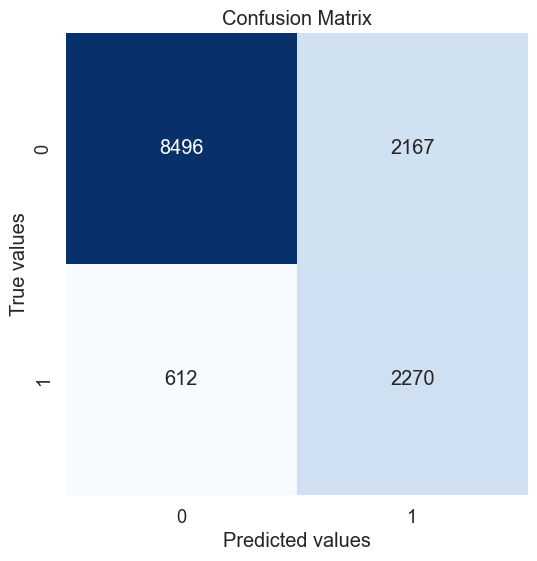

-------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86     10663
         1.0       0.51      0.79      0.62      2882

    accuracy                           0.79     13545
   macro avg       0.72      0.79      0.74     13545
weighted avg       0.84      0.79      0.81     13545

-------------------------
Accuracy Train Set: 0.797 Accuracy Test Set: 0.795


In [24]:
y_pred_test_rus= logreg_rus.predict(X_test)
y_pred_train_rus = logreg_rus.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_test_rus, y_train, y_pred_train_rus)

Again as before, we get a better recall score for class 1: 0.79 vs. 0.51 with the best parameter model. But the precision for class 1 remains very low and recall and f1 score for class 0 are lower than the onces of the best parameter model. Again we supect that the lower scores of class 0 might be due to the fact tha random undersampling sometimes changes the distribution of the data. The accuracy of this model with 0.798 is the lowest of all three over/undersampling methods. 

### 4. Conclusion Over/Undersampling

Applying any of the three models seems to greatly increase the recall score for class 1 but the precision scores are very low. 

It seems like without applying any of these methods to the data, we can get a higher precision score. 

The trade off seems to be between precision and recall.

Although the results are not very far from each other, SMOTE shows the best accuracy in the end. So let's do some hyperparameter tuning with SMOTE and see if get an even better result. 

### 5. Hyperparameter tuning with SMOTE 

### 5.1 GridSearchCV

In [25]:
logreg = LogisticRegression()
param_grid = {
    'C': [1, 10, 100, 1000, 10000, 100000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'fit_intercept': [True, False],
    'max_iter': [50, 100, 150],
    'random_state': [42]
}
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

logreg_sm_fit=grid_search.fit(X_sm, y_sm)

print("Best hyperparameters: ", grid_search.best_params_)
best_model_sm = grid_search.best_estimator_


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best hyperparameters:  {'C': 10, 'fit_intercept': False, 'max_iter': 50, 'random_state': 42, 'solver': 'liblinear'}


### 5.2 Best Parameter Fit 

In [26]:
dump(logreg_sm_fit, 'logreg_sm_fit.joblib')

['logreg_sm_fit.joblib']

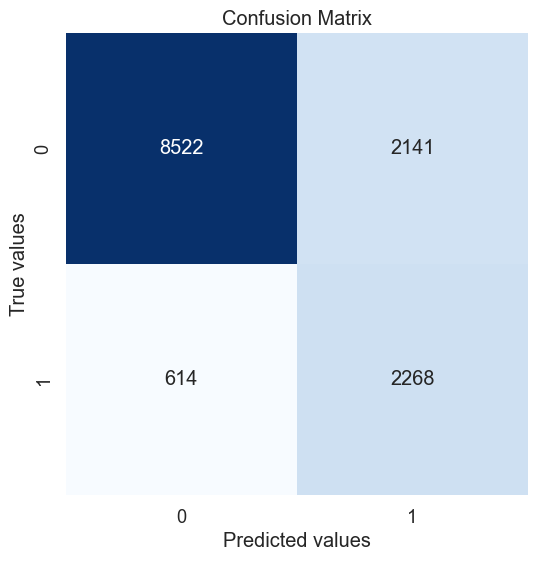

-------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86     10663
         1.0       0.51      0.79      0.62      2882

    accuracy                           0.80     13545
   macro avg       0.72      0.79      0.74     13545
weighted avg       0.84      0.80      0.81     13545

-------------------------
Accuracy Train Set: 0.799 Accuracy Test Set: 0.797


In [29]:
y_pred_test_best= best_model_sm.predict(X_test)
y_pred_train_best = best_model_sm.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_test_best, y_train, y_pred_train_best)

### 6. Boosting with SMOTE

In [30]:
logreg_sm_fit_boost = LogisticRegression(C=1, fit_intercept=True, max_iter=50, random_state=42, solver='liblinear')
ac = AdaBoostClassifier(base_estimator=logreg_sm_fit_boost,n_estimators=400)
ac.fit(X_sm,y_sm)

C:\Users\Abhishek\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=LogisticRegression(C=1, max_iter=50,
                                                     random_state=42,
                                                     solver='liblinear'),
                   n_estimators=400)

In [31]:
logreg_ac_fit = ac
dump(logreg_ac_fit, 'logreg_ac_fit.joblib')

['logreg_ac_fit.joblib']

In [32]:
logreg_ac_fit = load('logreg_ac_fit.joblib')

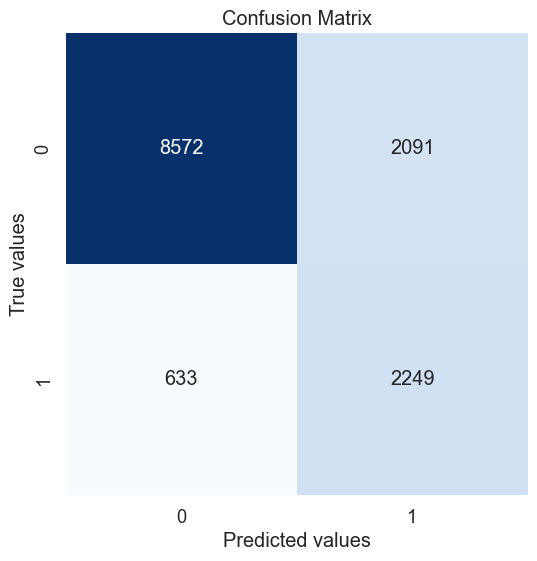

-------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86     10663
         1.0       0.52      0.78      0.62      2882

    accuracy                           0.80     13545
   macro avg       0.72      0.79      0.74     13545
weighted avg       0.84      0.80      0.81     13545

-------------------------
Accuracy Train Set: 0.8 Accuracy Test Set: 0.799


In [33]:
y_pred_ac = logreg_ac_fit.predict(X_test)
y_pred_train_ac = logreg_ac_fit.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_ac, y_train, y_pred_train_ac)

Adaptive boosting slighlty improved the results in terms of accuracy. And we do get a better recall score than with a tuned baseline model. 

### 7. Cross Validation 

In [34]:
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

cv_results = cross_validate(logreg_ac_fit, X_train, y_train, cv=5, return_estimator=True, scoring=scoring)

C:\Users\Abhishek\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Abhishek\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Abhishek\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Abhishek\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Abhishek\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [35]:
dump(cv_results, 'logreg_cv_results.joblib')

['logreg_cv_results.joblib']

In [36]:
logreg_cv_results = load('logreg_cv_results.joblib')

In [37]:
from tabulate import tabulate
fold_numbers = range(1,11)
test_precision = logreg_cv_results['test_precision']
test_recall = logreg_cv_results['test_recall']
test_f1_score = logreg_cv_results['test_f1_score']
table = [["Fold", "Test Precision", "Test Recall", "Test F1-Score"]]
for fold, prec, recall, f1 in zip(fold_numbers, test_precision, test_recall, test_f1_score):
    table.append([fold, f"{prec:.3f}", f"{recall:.3f}", f"{f1:.3f}"])

# Print table
print(tabulate(table, headers="firstrow", tablefmt="pretty"))

+------+----------------+-------------+---------------+
| Fold | Test Precision | Test Recall | Test F1-Score |
+------+----------------+-------------+---------------+
|  1   |     0.840      |    0.850    |     0.841     |
|  2   |     0.840      |    0.851    |     0.841     |
|  3   |     0.835      |    0.846    |     0.836     |
|  4   |     0.840      |    0.849    |     0.841     |
|  5   |     0.842      |    0.851    |     0.843     |
+------+----------------+-------------+---------------+


The hyperparameter-tuned baseline model has a great model accuracy of 0.85. However, the classification report gives us a low result for the recall score of class 1: The recall of 0.51 indicates that 51% of the actual class 1.0 instances were correctly predicted by the classifier which is worse than random classification. 

Also although the precision score of class 1 is higher with 0.70, it is not a great score either. It means when the classifier predicts class 1.0, it is correct only 70% of the time.

We thought that this was linked to the unbalanced nature of our dataset and when applying over as well as undersampling methods we do get better results for the recall score of class 1, however in the same time, the precision score of class 1 is between 0.51, not better than what we would get with a random classification. 

We tried to see if hyperparameter tuning with SMOTE and boosting our model leads to better scores. Adaptive boosting with SMOTE seemed to give us minutely better results. The accuracy is better than for the tuned baseline model and we also get a better recall score with over 0.78. Additionally, the precision, recall, and consequently f1 scores for class 0 are all over 86. 
Overall the Logistic regression model provided the worst results and should not be considered against other models.